In [548]:
from include.Wine_data import *
from include.Fire_data import *
from sklearn.model_selection import StratifiedKFold, learning_curve
from time import perf_counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import homogeneity_score

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
def plot_loss_accuracy(history, baseline=None):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    if baseline != None:
        historydf['baseline']=baseline
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(max(0, historydf.values.min()), max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    vloss = history.history['val_loss'][-1]
    vacc = history.history['val_accuracy'][-1]
    plt.title('Loss: %.3f, Acc: %.3f, vLoss: %.3f, vAcc: %.3f' % (loss, acc, vloss, vacc))
    
def train_validate_fold(model, _X_train, _y_train, _X_val, _y_val, epochs=200):
    model.get_weights()
    print("training for ", epochs, "epochs")
    model.fit(_X_train, _y_train, epochs=epochs, verbose = 0)
    scores = model.evaluate(_X_val, _y_val, verbose=0)
    return scores

In [536]:
wine = Wine.load_pickle()
#a summary
print("train data pos percentage", len(wine.y_train[wine.y_train['good']==1]) / len(wine.y_train))
print("test data pos percentage", len(wine.y_test[wine.y_test['good']==1]) / len(wine.y_test))
print("size of training", len(wine.X_train))

loading pickle:  ../data/pickles/Wine.pickle
test data pos percentage 0.5254691689008043
test data pos percentage 0.55625
size of training 1119


In [583]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.best_map10 = 0
        self.best_v_accuracy = 0
    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        v_accuracy = logs.get('val_accuracy')
        map10=logs.get('val_average_precision_at_k10')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.greater(v_accuracy, self.best_v_accuracy):
            self.best_v_loss = v_loss
            self.best_v_accuracy = v_accuracy
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


def nn(X_train, y_train,  X_test, y_test, layers = [16, 8], lr=0.001, batch_size=10, epochs = 100, verbose = 0, validation_split=0.2):
    print("creating new model")
    _model = Sequential()
    _X_train, _X_validation, _y_train, _y_validation = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state = 1)
    for i,l in enumerate(layers):
        if i == 0 : 
            _model.add(Dense(l, activation='relu', input_shape=(_X_train.shape[1],)))
        else:
            _model.add(Dense(l, activation='relu'))
    es = EarlyStopping(monitor='val_accuracy', patience=50)
    t = perf_counter()
    result = {'layers':layers, 'lr':lr, 'batch_size':batch_size}
    _model.add(Dense(1, activation='sigmoid'))
    _model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    result['history'] = _model.fit(_X_train, _y_train, epochs=epochs, verbose=verbose,  batch_size=batch_size, validation_data=(_X_validation, _y_validation) , callbacks=[CustomEarlyStopping(patience=40)])#callbacks = [es])
    result['time'] = perf_counter() - t
    result['it'] = len(result['history'].history['loss'])
    result['val_accuracy'] = result['history'].history['val_accuracy'][-1]
    result['model'] = _model
    return result


def nn_search(X_train, y_train,  X_test, y_test, layers=[[16,8]], lrs=[0.001], batch_sizes=[10], epochs=1000):
    results = []
    for l in layers:
        for lr in lrs:
            for batch_size in batch_sizes:
                results.append(
                    nn(
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        layers = l,
                        lr = lr,
                        batch_size = batch_size,
                        epochs = epochs
                    )
                )
    return results


def nn_experiment(obj = wine, exp = None, layers = None):
    if layers is None:
        layers =[[2,2],[4,4],[8,4],[16,8],[32,16],[64,32],[64,64]]
    _X_train = obj.X_train
    _X_test = obj.X_test
    if exp is not None:
        _X_train = obj.models[exp]['X_train']
        _X_test = obj.models[exp]['X_test']
        
    results = nn_search(
        X_train = _X_train,
        y_train = obj.y_train,
        X_test = _X_test,
        y_test = obj.y_test,
        layers = layers,
        batch_sizes=[None],
        epochs = 500
    )
    for r in results:
        print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(_X_test, obj.y_test))
    return results

In [534]:
results_raw = nn_experiment(obj = wine, exp= None)

Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.5810 - accuracy: 0.7250
result:  0.7232142686843872 [2, 2] it: 94 time 7.312902558129281 [0.5809897184371948, 0.7250000238418579]
15/15 [==============================] - 0s 2ms/step - loss: 0.5644 - accuracy: 0.7167
result:  0.7098214030265808 [4, 4] it: 96 time 7.442150889895856 [0.5644316077232361, 0.7166666388511658]
15/15 [===================

<Figure size 576x432 with 0 Axes>

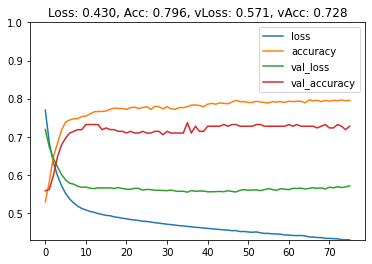

In [537]:
plot_loss_accuracy(results_raw[3]['history'])

In [538]:
results_pca = nn_experiment(obj=wine, exp = 'pca')

Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5542
result:  0.5267857313156128 [2, 2] it: 84 time 6.9936206170823425 [0.6890854239463806, 0.5541666746139526]
15/15 [==============================] - 0s 1ms/step - loss: 0.5828 - accuracy: 0.7104
result:  0.6919642686843872 [4, 4] it: 80 time 6.713903613155708 [0.5828141570091248, 0.7104166746139526]
15/15 [==================

<Figure size 576x432 with 0 Axes>

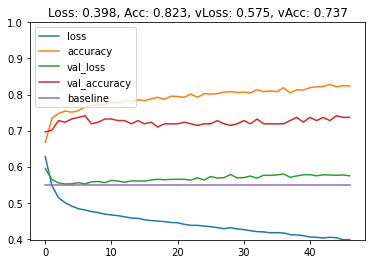

In [542]:
plot_loss_accuracy(results_pca[5]['history'], baseline=0.55)


In [539]:
results_ica = nn_experiment(obj=wine, exp = 'ica')

Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.6979
result:  0.7410714030265808 [2, 2] it: 95 time 7.599530533887446 [0.568376898765564, 0.6979166865348816]
15/15 [==============================] - 0s 1ms/step - loss: 0.5510 - accuracy: 0.7188
result:  0.7098214030265808 [4, 4] it: 81 time 6.26963297999464 [0.5509731769561768, 0.71875]
15/15 [==============================] 

<Figure size 576x432 with 0 Axes>

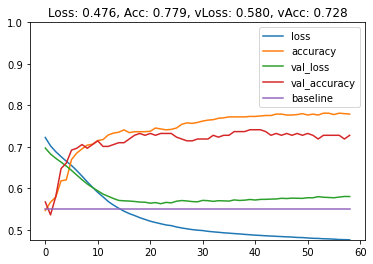

In [544]:
plot_loss_accuracy(results_ica[2]['history'], baseline=0.55)


In [540]:
results_rp = nn_experiment(obj=wine, exp = 'rp')

Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.6437 - accuracy: 0.6354
result:  0.6696428656578064 [2, 2] it: 115 time 8.449075635056943 [0.6437408924102783, 0.6354166865348816]
15/15 [==============================] - 0s 1ms/step - loss: 0.6436 - accuracy: 0.6333
result:  0.6696428656578064 [4, 4] it: 149 time 10.838547476800159 [0.6435768008232117, 0.6333333253860474]
15/15 [================

<Figure size 576x432 with 0 Axes>

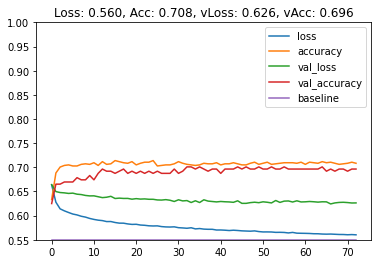

In [545]:
plot_loss_accuracy(results_rp[3]['history'], baseline=0.55)


In [541]:
results_dt = nn_experiment(obj=wine, exp = 'dt')

Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.5581 - accuracy: 0.7271
result:  0.7232142686843872 [2, 2] it: 106 time 9.931772405980155 [0.5581333041191101, 0.7270833253860474]
15/15 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.6875
result:  0.71875 [4, 4] it: 66 time 5.646165709942579 [0.5730069875717163, 0.6875]
15/15 [==============================] - 0s 1ms/

<Figure size 576x432 with 0 Axes>

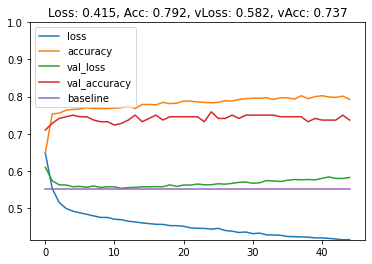

In [547]:
plot_loss_accuracy(results_dt[5]['history'], baseline=0.55)


In [580]:
wine.models['km']['X_train']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,cluster
925,0.161077,-1.719632,0.36,-0.453218,0.064,3.550300,0.928453,-0.374550,1.029472,1.250199,0.541630,1
363,2.401746,-0.378878,0.63,-0.382271,0.071,-0.944346,-0.956903,1.088288,-2.080582,1.250199,-0.209308,2
906,-0.643266,0.068040,0.27,0.043416,0.084,-0.370562,0.958862,-0.183745,0.511130,0.305990,0.541630,0
426,-1.102890,0.794282,0.08,-0.311323,0.045,0.298854,0.046593,-0.978765,1.159057,-0.992298,0.917099,0
1251,-0.470907,0.291499,0.14,-0.240375,0.077,1.063900,0.411500,-0.236746,-0.201591,-0.402167,-0.584777,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.448342,0.403229,0.00,-0.453218,0.058,-1.039977,-1.108948,0.505273,-0.849519,-0.166115,-0.021574,2
1294,-0.068735,0.598756,0.10,-0.311323,0.073,0.872638,0.411500,-0.194345,-0.136798,0.542042,0.447763,1
860,-0.643266,0.514959,0.06,0.114364,0.077,-0.083669,1.171725,0.378070,1.288643,-0.697233,-0.866379,1
1459,-0.241094,-1.831362,0.35,-0.595114,0.054,-0.848716,-0.956903,-1.148370,0.057580,0.837107,1.386435,0


In [581]:
results_km = nn_experiment(obj=wine, exp = 'km')

Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.5906 - accuracy: 0.7167
result:  0.7142857313156128 [2, 2] it: 81 time 6.163557168096304 [0.5906143188476562, 0.7166666388511658]
15/15 [==============================] - 0s 1ms/step - loss: 0.5398 - accuracy: 0.7312
result:  0.7410714030265808 [4, 4] it: 133 time 11.779105335939676 [0.539836585521698, 0.731249988079071]
15/15 [===================

<Figure size 576x432 with 0 Axes>

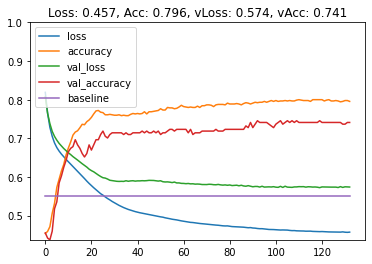

In [586]:
plot_loss_accuracy(results_km[1]['history'], baseline=0.55)


In [584]:
results_em = nn_experiment(obj=wine, exp = 'em')

creating new model
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
creating new model
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
creating new model
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
creating new model
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
creating new model
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
creating new model
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
creating new model
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.5664 - accuracy: 0.7083
result:  0.7321428656578064 [2, 2] it: 91 time 7.615857433062047 [0.5664476156234741, 0.7083333134651184]
15/15 [==============================] - 0s 2ms/step - loss: 0.5732 - accuracy: 0.7271

<Figure size 576x432 with 0 Axes>

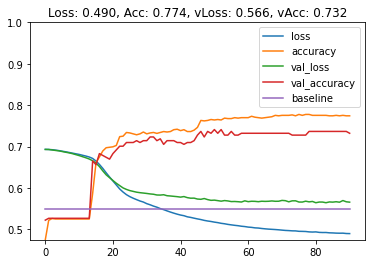

In [585]:
plot_loss_accuracy(results_em[0]['history'], baseline=0.55)
